In [1]:
# !pip install aeon
# !pip install scikeras
# !pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 107.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.2 MB/s eta 0:00:00a 0:00:01


In [1]:
from aeon.datasets import load_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import random
import torch
import torch.nn as nn
from pyts.image import GramianAngularField
import numpy as np

2024-03-20 21:22:56.817721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 21:22:59.199741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. GunPoint

In [2]:
# X, y, metadata = load_classification(name="GunPoint",return_metadata=True)
# y = np.array([int(i)-1 for i in y])
# X.shape , y.shape

In [2]:
def load_dataset(PATH):
  loaded_data = np.load(PATH)
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']
  indices = loaded_data['indices']
  X_train_deq = X_train[indices]
  y_train_deq = y_train[indices]

  return X_train, X_test, X_train_deq, y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0]), y_train_deq.reshape(y_train_deq.shape[0])

gpds = load_dataset('gunpoint.npz')
gpds[0].shape , gpds[3].shape

((160, 1, 150), (160,))

## 1.1 Preprocessing Data - BALANCED Dataset

### 1.1.1 Splitting Data

In [3]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test = gpds[0],gpds[1],gpds[3],gpds[4]

X_train = X_train.reshape(X_train.shape[0],X_train.shape[2],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2],X_test.shape[1])

X_train.shape, X_test.shape, type(X_train[0][0][0]), type(y_train[0])

((160, 150, 1), (40, 150, 1), numpy.float64, numpy.int64)

### 1.1.2 Transforming data to image.

Applying GASF transformation

(160, 150, 150) (40, 150, 150)


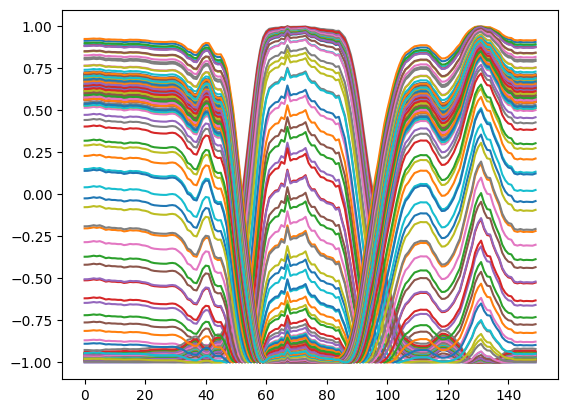

In [4]:
def transform_to_gasf(series,min_train,max_train):
    normalized_series = (series - min_train) / (max_train - min_train)
    gasf_transformer = GramianAngularField(image_size=normalized_series.shape[0], method='summation')
    gasf_image = gasf_transformer.fit_transform(normalized_series.reshape(1, -1))
    return gasf_image[0]

min_train = np.min([sample for sample in X_train])
max_train = np.max([sample for sample in X_train])

# Transform the entire dataset
X_train_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_train])
X_test_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_test])

print(X_train_gasf.shape , X_test_gasf.shape)
plt.plot(X_train_gasf[0])

## 1.2 LSTM Model Architecture with 1 layer LSTM

In [5]:
class LSTM_classifier:
    def __init__(self,input_shape,lstm_units=50,dense_units=100,dropout=0.5,optimizer='adam',binary=True, metrics = ['accuracy']):
        self.model = Sequential()
        self.model.add(LSTM(lstm_units,input_shape=input_shape))
        self.model.add(Dropout(dropout))
        self.model.add(Dense(dense_units,activation='relu'))

        if binary:
            self.model.add(Dense(1,activation='sigmoid'))
            self.model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= metrics)
        else:
            self.model.add(Dense(1,activation='softmax'))
            self.model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= metrics)

    def train(self, X_train, y_train,epochs=15, batch_size=32):
        early_stop = EarlyStopping(monitor='val_loss',patience = 10, verbose = 1, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_model_1_layerLSTM.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        return self.model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[checkpoint,early_stop])

    def evaluate(self,X_test,y_test):
        return self.model.evaluate(X_test,y_test)

    def predict(self,X_test):
        return self.model.predict(X_test)

In [6]:
# performing cross-validation
# timeframes = X_train_gasf.shape[1]
# features = X_train_gasf.shape[-1]

# def create_model(input_shape,lstm_units=50,dense_units=100,dropout=0.5,optimizer='adam',binary=True, metrics = ['accuracy']):
#         model = Sequential()
#         model.add(LSTM(lstm_units,input_shape=input_shape))
#         model.add(Dropout(dropout))
#         model.add(Dense(dense_units,activation='relu'))

#         if binary:
#             model.add(Dense(1,activation='sigmoid'))
#             model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics= metrics)
#         else:
#             model.add(Dense(1,activation='softmax'))
#             model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= metrics)
#         return model

# early_stop = EarlyStopping(monitor='loss',patience = 15, verbose = 1, restore_best_weights=True)

# model_lstm1 = KerasClassifier(build_fn=create_model,input_shape=(timeframes,features),epochs=100,optimizer='adam',verbose=1,callbacks=[early_stop])

# param_grid = {
#     'model__lstm_units': [50,100,200],
#     'model__dense_units': [50,100,150],
#     'model__dropout': [0.5,0.2],
#     'batch_size': [16,32]
# }

# grid_lstm1 = GridSearchCV(estimator=model_lstm1,param_grid=param_grid,n_jobs=-1,cv=2, verbose=2)

# grid_lstm1_result = grid_lstm1.fit(X_train_norm, y_train)
# [grid_lstm1_result.best_score_, grid_lstm1_result.best_params_]

In [7]:
timeframes = X_train_gasf.shape[1]
features = X_train_gasf.shape[-1]

batch_size = 16 #grid_lstm1_result.best_params_['batch_size']
dense_units = 150 #grid_lstm1_result.best_params_['model__dense_units']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
lstm_units = 100 #grid_lstm1_result.best_params_['model__lstm_units']

LSTM_model = LSTM_classifier(input_shape=(timeframes,features),lstm_units=lstm_units,dense_units=dense_units,dropout=dropout)
history = LSTM_model.train(X_train_gasf,y_train,batch_size=batch_size,epochs=100)

2024-03-19 17:15:21.423266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23253 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2024-03-19 17:15:21.432890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3991 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a3:00.0, compute capability: 8.0
2024-03-19 17:15:21.434919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 20667 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
/home/infres/acosta-23/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input

Epoch 1/100


2024-03-19 17:15:23.858976: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5556 - loss: 0.6735
Epoch 1: val_loss improved from inf to 0.58441, saving model to best_model_1_layerLSTM.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5625 - loss: 0.6690 - val_accuracy: 0.7188 - val_loss: 0.5844
Epoch 2/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8750 - loss: 0.5168
Epoch 2: val_loss improved from 0.58441 to 0.46259, saving model to best_model_1_layerLSTM.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7988 - loss: 0.5021 - val_accuracy: 0.8750 - val_loss: 0.4626
Epoch 3/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8408 - loss: 0.3728
Epoch 3: val_loss improved from 0.46259 to 0.31527, saving model to best_model_1_layerLSTM.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8432 - loss: 0.3703 - val_accuracy: 0.9375 - val_loss: 0.3153
Epoch 4/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9375 - loss: 0.2010
Epoch 4: val_loss did not improve from 0.31527


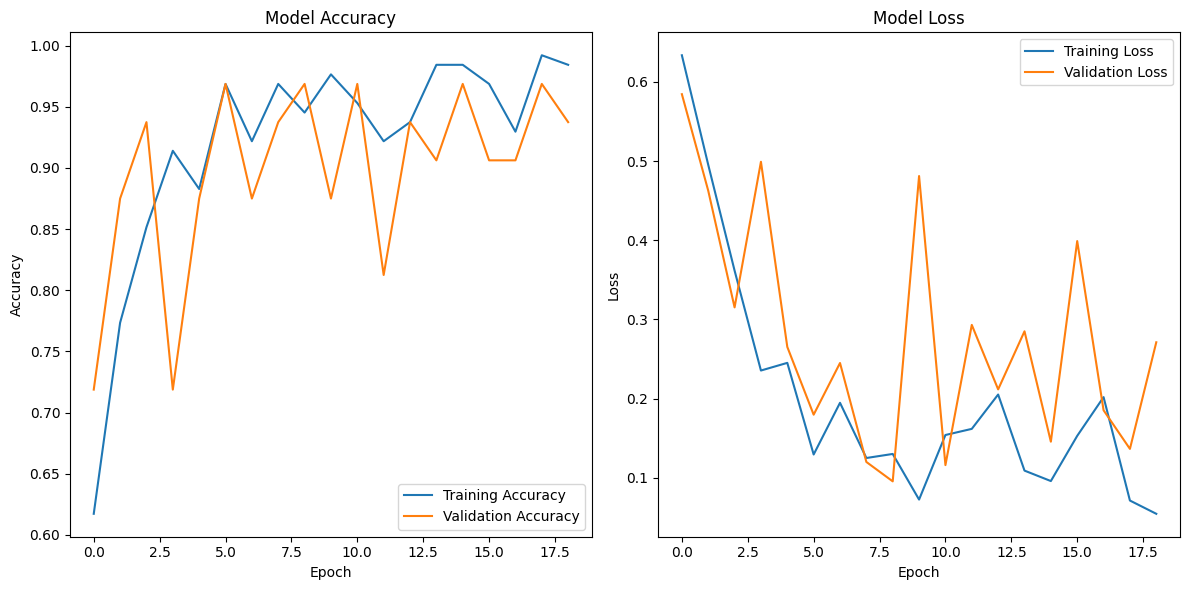

In [8]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [9]:
model = load_model('best_model_1_layerLSTM.keras')
loss, accuracy = model.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9187 - loss: 0.1182
Test Accuracy: 92.50%
Errors = 3


## 1.3 Other LSTM architechture - 2 layers LSTM instead of just one

In [10]:
def build_model(input_shape,lstm_units=50,dropout=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [11]:
### ---------- CROSS-VALIDATION ------------ ###

# model_lstm2 = KerasClassifier(build_fn=build_model,input_shape=(timeframes,features),epochs=100,optimizer='adam',verbose=1,callbacks=[early_stop])

# param_grid = {
#     'model__lstm_units': [50,100,200],
#     'model__dropout': [0.5,0.2],
#     'batch_size': [16,32]
# }

# grid_lstm2 = GridSearchCV(estimator=model_lstm2,param_grid=param_grid,n_jobs=-1,cv=2, verbose=5)

# grid_lstm2_result = grid_lstm2.fit(X_train_norm, y_train)
# [grid_lstm1_result.best_score_, grid_lstm1_result.best_params_]

In [12]:
batch_size = 16 #grid_lstm1_result.best_params_['batch_size']
dropout = 0.2 #grid_lstm1_result.best_params_['model__dropout']
lstm_units = 100 #grid_lstm1_result.best_params_['model__lstm_units']

model = build_model((X_train_gasf.shape[1], X_train_gasf.shape[2]),lstm_units,dropout)
history = model.fit(X_train_gasf, y_train, epochs=100, batch_size=batch_size, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6096 - loss: 0.6660
Epoch 1: val_loss improved from inf to 0.53627, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.6234 - loss: 0.6550 - val_accuracy: 0.7812 - val_loss: 0.5363
Epoch 2/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8651 - loss: 0.3911
Epoch 2: val_loss improved from 0.53627 to 0.34043, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8684 - loss: 0.3891 - val_accuracy: 0.8750 - val_loss: 0.3404
Epoch 3/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9293 - loss: 0.1918
Epoch 3: val_loss improved from 0.34043 to 0.22548, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9321 - loss: 0.1902 - val_accuracy: 0.9375 - val_loss: 0.2255
Epoch 4/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9656 - loss: 0.0926
Epoch 4: val_loss improved from 0.22548 to 0.09905, saving model to best_model.ker

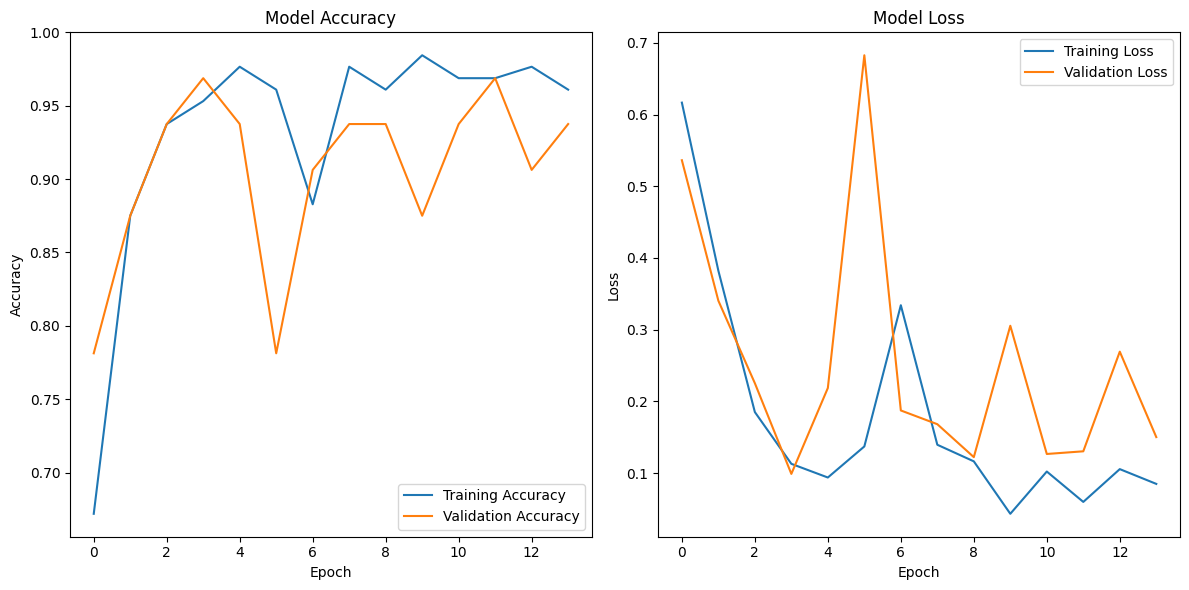

In [13]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()


In [14]:
model = load_model('best_model.keras')
loss, accuracy = model.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9458 - loss: 0.0624
Test Accuracy: 95.00%
Errors = 2


## 1.4 Pytorch LSTM (same 2 layers architechture)

In [59]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim,hidden_dim,n_layers,dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # LSTM layer(s) with dropout
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, self.n_layers,batch_first=True,dropout=dropout)
        
        # Final dense layer for binary classification
        self.dense = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        # Passing data through the first LSTM layer

        h0 = torch.randn(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.randn(self.n_layers, x.size(0), self.hidden_dim).to(x.device)

        # print(x.shape)

        x, _ = self.lstm(x, (h0, c0))
        
        # Only take the output from the last time step
        x = x[:, -1, :]
        
        # Passing through the dense layer
        x = self.dense(x)
        return x


In [60]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [61]:
X_train_pytorch, X_val, y_train_pytorch, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

min_train = np.min([sample for sample in X_train_pytorch])
max_train = np.max([sample for sample in X_train_pytorch])

# Transform the entire dataset
X_train_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_train_pytorch])
X_val_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_val])
X_test_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_test])

# loading dataloader
train_dataset = TimeSeriesDataset(X_train_gasf, y_train)
val_dataset = TimeSeriesDataset(X_val_gasf, y_val)
test_dataset = TimeSeriesDataset(X_test_gasf, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [62]:
X_train_gasf.shape, y_train_pytorch, len(y_train_pytorch)

((128, 150, 150),
 array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]),
 128)

In [63]:
def save_checkpoint(model, filename="best_model_pytorch.pth"):
    torch.save(model.state_dict(), filename)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100,early_stop=10):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_accuracy = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(1), y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            predictions = (torch.sigmoid(outputs)>0.5)*1
            total_train_accuracy += (predictions.squeeze(1) == y_batch).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader.dataset)

        # Validation
        # if epoch%5 == 0:
        model.eval()
        total_val_loss, total_val_accuracy = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(1), y_batch)
                total_val_loss += loss.item()
                predictions = (torch.sigmoid(outputs)>0.5)*1
                total_val_accuracy += (predictions.squeeze(1) == y_batch).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader.dataset)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

        # Checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            save_checkpoint(model, "best_model.pth")
        else:
            epochs_no_improve+=1
            if epochs_no_improve >= early_stop:
              print(f"Early stop triggered at epoch {epoch} !!!")
              break

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

    return history

In [64]:
torch.manual_seed(43)
input_dim = X_train_gasf.shape[1:][0]
hidden_dim = 100
n_layers = 2
model = LSTMClassifier(input_dim, hidden_dim,n_layers)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = train_model(model, criterion, optimizer, train_loader,val_loader ,epochs=150)

Epoch 1/150, Train Loss: 0.6958, Train Accuracy: 0.4844, Val Loss: 0.6822, Val Accuracy: 0.5938
Epoch 2/150, Train Loss: 0.6879, Train Accuracy: 0.5547, Val Loss: 0.6767, Val Accuracy: 0.5938
Epoch 3/150, Train Loss: 0.6846, Train Accuracy: 0.5547, Val Loss: 0.6749, Val Accuracy: 0.5625
Epoch 4/150, Train Loss: 0.6784, Train Accuracy: 0.5469, Val Loss: 0.6620, Val Accuracy: 0.5938
Epoch 5/150, Train Loss: 0.6726, Train Accuracy: 0.6016, Val Loss: 0.6510, Val Accuracy: 0.6875
Epoch 6/150, Train Loss: 0.6672, Train Accuracy: 0.5859, Val Loss: 0.6566, Val Accuracy: 0.5938
Epoch 7/150, Train Loss: 0.6571, Train Accuracy: 0.6016, Val Loss: 0.6644, Val Accuracy: 0.5938
Epoch 8/150, Train Loss: 0.6489, Train Accuracy: 0.6250, Val Loss: 0.6423, Val Accuracy: 0.6562
Epoch 9/150, Train Loss: 0.6116, Train Accuracy: 0.6562, Val Loss: 0.7514, Val Accuracy: 0.5625
Epoch 10/150, Train Loss: 0.6118, Train Accuracy: 0.6406, Val Loss: 0.8154, Val Accuracy: 0.5312
Epoch 11/150, Train Loss: 0.6000, Train

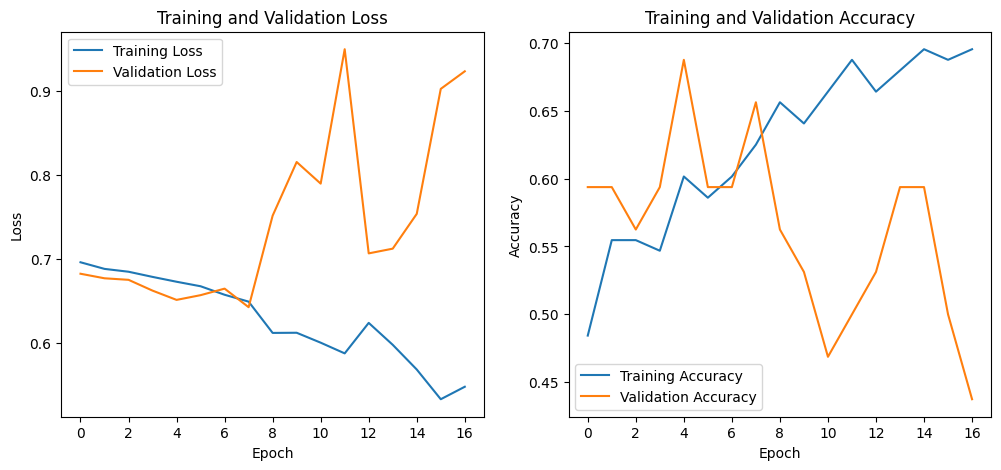

In [65]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [66]:
model.load_state_dict(torch.load('best_model.pth'))
def evaluate_model(model, test_loader):
    model.eval()
    total_loss, total_accuracy = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            total_loss += loss.item()
            predictions = torch.sigmoid(outputs).round()
            total_accuracy += (predictions.squeeze(1) == y_batch).sum().item()
    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)
    return avg_loss, avg_accuracy

# Assuming test_loader is a DataLoader object for your test data
test_loss, test_accuracy = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
print(f'Errors = {int(len(y_test) - len(y_test)*test_accuracy)}')

Test Loss: 0.6739734212557474, Test Accuracy: 0.725
Errors = 11


## 1.5 Preprocessing Data - UNBALANCED Dataset

### 1.5.1 Unbalancing Dataset

In [67]:
def make_dataset_imbalanced(X, y, class_to_reduce=0, reduction_factor=0.1):
    """
    Reduces the number of samples in the specified class by the reduction factor.

    Parameters:
    X (np.array): Feature data.
    y (np.array): Labels.
    class_to_reduce (int): The class whose samples are to be reduced.
    reduction_factor (float): The fraction of the class_to_reduce samples to keep (0 < reduction_factor <= 1).

    Returns:
    (np.array, np.array): The imbalanced features and labels.
    """
    # Indices of the class to reduce and the other class
    reduce_indices = np.where(y == class_to_reduce)[0]
    other_indices = np.where(y != class_to_reduce)[0]

    # Randomly select a subset of the class to reduce
    reduced_indices = np.random.choice(reduce_indices, int(len(reduce_indices) * reduction_factor), replace=False)

    # Combine the reduced class indices with the other class indices
    new_indices = np.concatenate([reduced_indices, other_indices])
    np.random.shuffle(new_indices)  # Shuffle the indices to mix the classes

    # Create the new imbalanced dataset
    X_imbalanced = X[new_indices]
    y_imbalanced = y[new_indices]

    return X_imbalanced, y_imbalanced

In [5]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# X_train_reduced, y_train_reduced = make_dataset_imbalanced(X_train, y_train, class_to_reduce=1, reduction_factor=0.1)
X_train_reduced, y_train_reduced = gpds[2], gpds[-1]
X_train_reduced = X_train_reduced.reshape(X_train_reduced.shape[0],X_train_reduced.shape[2],X_train_reduced.shape[1])
X_train_reduced.shape, y_train_reduced.shape

((88, 150, 1), (88,))

In [6]:
y_train_reduced, y_train_reduced.sum()

(array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]),
 80)

### 1.5.2 Normalizing Data

(88, 150, 150)


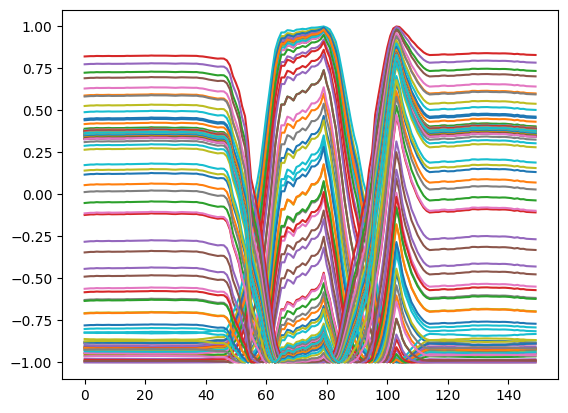

In [7]:
min_train = np.min([sample for sample in X_train_reduced])
max_train = np.max([sample for sample in X_train_reduced])

X_train_reduced_gasf = np.array([transform_to_gasf(sample,min_train,max_train) for sample in X_train_reduced])
print(X_train_reduced_gasf.shape)
plt.plot(X_train_reduced_gasf[0])

In [72]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unbalanced_model = build_model((X_train_reduced_gasf.shape[1], X_train_reduced_gasf.shape[2]))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_unbalanced.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_unb = unbalanced_model.fit(X_train_reduced_gasf, y_train_reduced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1250 - loss: 0.8103
Epoch 1: val_loss improved from inf to 1.04206, saving model to best_model_unbalanced.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.5719 - loss: 0.5602 - val_accuracy: 0.7778 - val_loss: 1.0421
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9375 - loss: 0.2923
Epoch 2: val_loss did not improve from 1.04206
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9493 - loss: 0.2542 - val_accuracy: 0.7778 - val_loss: 1.3903
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0219
Epoch 3: val_loss did not improve from 1.04206
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9549 - loss: 0.1699 - val_accuracy: 0.7778 - val_loss: 1.1885
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0411
Epoch 4: val_loss did not improve from 1.04206
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9584 - loss: 0.1396 - val_accuracy: 0.7778 - val_l

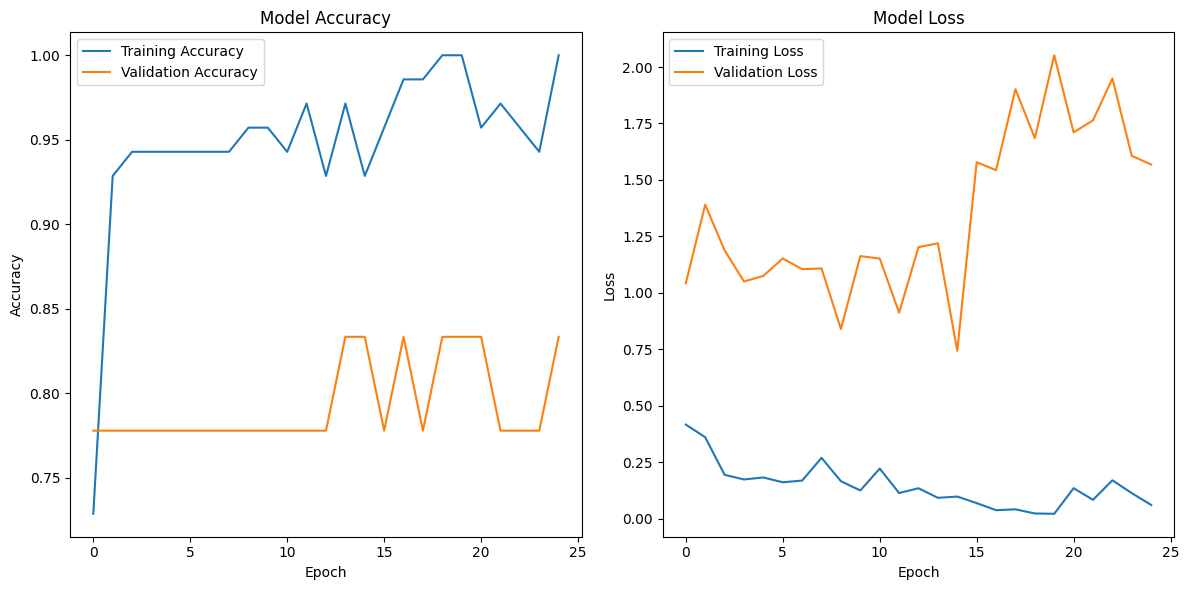

In [73]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_unb.history['accuracy'], label='Training Accuracy')
plt.plot(history_unb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_unb.history['loss'], label='Training Loss')
plt.plot(history_unb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [75]:
model_unbalanced = load_model('best_model_unbalanced.keras')
loss, accuracy = model_unbalanced.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7438 - loss: 0.8088
Test Accuracy: 72.50%
Errors = 11


## 1.6 Applying Class Weights

In [77]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_reduced), y=y_train_reduced)

# Convert class_weights to a dictionary to pass it to Keras
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 5.5, 1: 0.55}

In [79]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unbalanced_model = build_model((X_train_reduced_gasf.shape[1], X_train_reduced_gasf.shape[2]))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_unbalanced.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_unb = unbalanced_model.fit(X_train_reduced_gasf, y_train_reduced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop],class_weight=class_weights_dict)

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8740 - loss: 0.5256
Epoch 1: val_loss improved from inf to 0.68418, saving model to best_model_unbalanced.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8760 - loss: 0.5802 - val_accuracy: 0.7778 - val_loss: 0.6842
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9375 - loss: 0.1929
Epoch 2: val_loss improved from 0.68418 to 0.66671, saving model to best_model_unbalanced.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9016 - loss: 0.4256 - val_accuracy: 0.5000 - val_loss: 0.6667
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8125 - loss: 0.4412
Epoch 3: val_loss improved from 0.66671 to 0.65460, saving model to best_model_unbalanced.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7190 - loss: 0.4626 - val_accuracy: 0.5000 - val_loss: 0.6546
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6135 - loss: 0.4549
Epoch 4: val_loss improved from 0.65460 to 0.6427

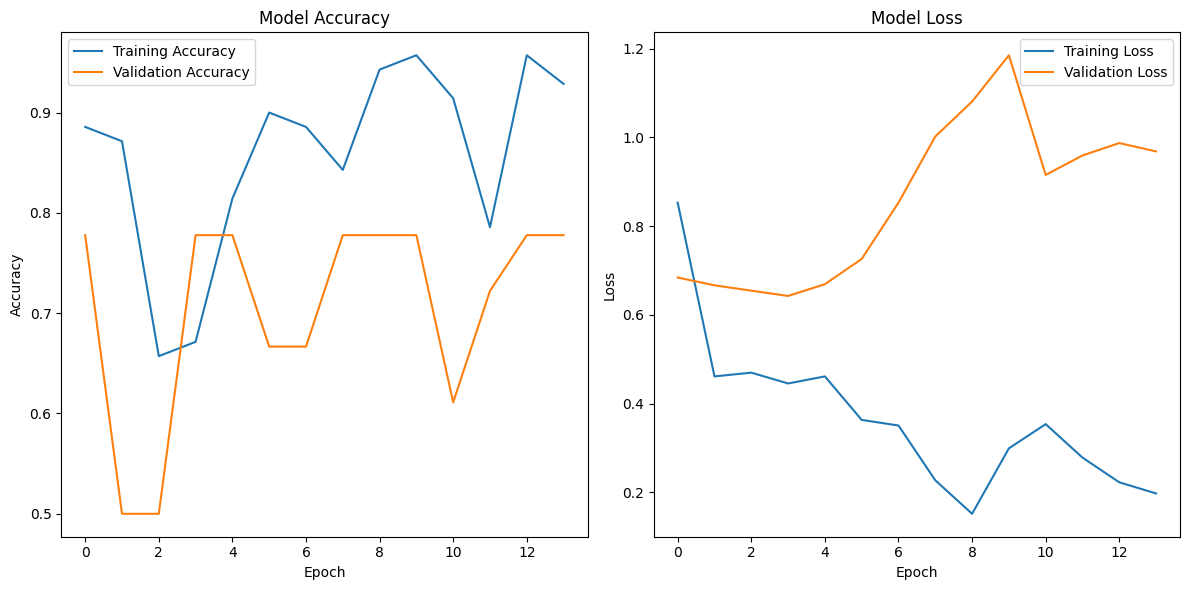

In [80]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_unb.history['accuracy'], label='Training Accuracy')
plt.plot(history_unb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_unb.history['loss'], label='Training Loss')
plt.plot(history_unb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [81]:
model_unbalanced = load_model('best_model_unbalanced.keras')
loss, accuracy = model_unbalanced.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7063 - loss: 0.6475  
Test Accuracy: 70.00%
Errors = 12


## 1.7 Rebalancing the dataset with Artificially Generated Images

### 1.7.1 GAN

In [82]:
gen_imgs = np.load('gen_images.npy')
gen_ohe_labels = np.load('gen_labels.npy')
gen_imgs.shape , gen_ohe_labels.shape

((200, 150, 150), (200, 2))

In [83]:
def transform_labels(gen_ohe_labels):
    return np.where(gen_ohe_labels == 1)[-1]

gen_labels = transform_labels(gen_ohe_labels)
print(gen_labels)
gen_imgs.shape , gen_labels.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


((200, 150, 150), (200,))

In [84]:
def random_idx_selection(gen_labels,seed=0, cls = 0, amount = 72):
    indices_class_x = np.where(gen_labels == cls)[0]
    np.random.seed(seed)

    # Randomly select 80 indices of class 0
    selected_indices = np.random.choice(indices_class_x, size=amount, replace=False)
    assert(selected_indices.all() < len(gen_labels)/2)
    return selected_indices

selected_idx = random_idx_selection(gen_labels)
selected_idx

array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29])

In [85]:
# rebalacing the vector
selected_elements = gen_imgs[selected_idx]
selected_labels = gen_labels[selected_idx]
X_train_rebalanced = np.concatenate((X_train_reduced_gasf,selected_elements))
y_train_rebalanced = np.concatenate((y_train_reduced,selected_labels))
X_train_rebalanced.shape , y_train_rebalanced.shape, y_train_rebalanced.sum()

((160, 150, 150), (160,), 80)

In [92]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

genimgs_model = build_model((X_train_rebalanced.shape[1], X_train_rebalanced.shape[2]))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_genimgs.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_genimgs = genimgs_model.fit(X_train_rebalanced, y_train_rebalanced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100


/home/infres/acosta-23/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5931 - loss: 0.6694
Epoch 1: val_loss improved from inf to 1.22102, saving model to best_model_genimgs.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6102 - loss: 0.6562 - val_accuracy: 0.1250 - val_loss: 1.2210
Epoch 2/100
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5942 - loss: 0.6642
Epoch 2: val_loss improved from 1.22102 to 0.59905, saving model to best_model_genimgs.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6391 - loss: 0.6182 - val_accuracy: 0.6562 - val_loss: 0.5990
Epoch 3/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8675 - loss: 0.4244
Epoch 3: val_loss improved from 0.59905 to 0.17782, saving model to best_model_genimgs.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8599 - loss: 0.4197 - val_accuracy: 1.0000 - val_loss: 0.1778
Epoch 4/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8278 - loss: 0.3775 
Epoch 4: val_loss did not improve from 0.17782
8/8 ━━━━━━━

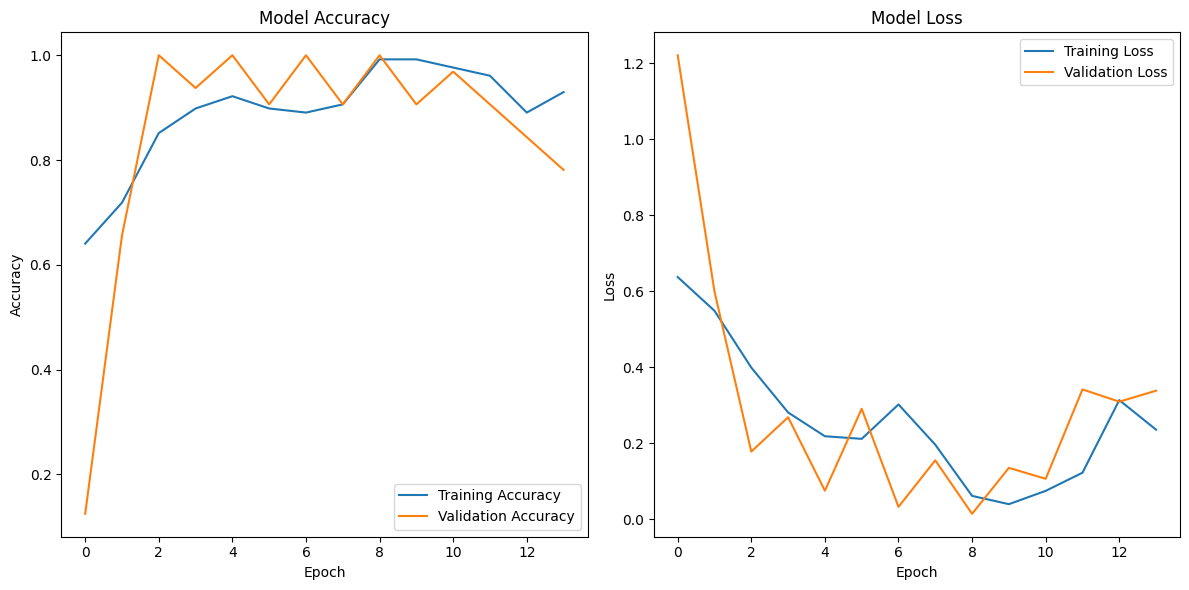

In [93]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_genimgs.history['accuracy'], label='Training Accuracy')
plt.plot(history_genimgs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_genimgs.history['loss'], label='Training Loss')
plt.plot(history_genimgs.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [94]:
model_genimgs = load_model('best_model_genimgs.keras')
loss, accuracy = model_genimgs.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9458 - loss: 0.1418  
Test Accuracy: 95.00%
Errors = 2


### 1.7.2 DCGAN

In [102]:
gen_imgs = np.load('gen_images_DCGAN.npy')
gen_ohe_labels = np.load('gen_labels_DCGAN.npy')
gen_imgs.shape , gen_ohe_labels.shape

((200, 150, 150), (200, 2))

In [103]:
def transform_labels(gen_ohe_labels):
    return np.where(gen_ohe_labels == 1)[-1]

gen_labels = transform_labels(gen_ohe_labels)
print(gen_labels)
gen_imgs.shape , gen_labels.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


((200, 150, 150), (200,))

In [104]:
def random_idx_selection(gen_labels,seed=0, cls = 0, amount = 72):
    indices_class_x = np.where(gen_labels == cls)[0]
    np.random.seed(seed)

    # Randomly select 80 indices of class 0
    selected_indices = np.random.choice(indices_class_x, size=amount, replace=False)
    assert(selected_indices.all() < len(gen_labels)/2)
    return selected_indices

selected_idx = random_idx_selection(gen_labels)
selected_idx

array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29])

In [105]:
# rebalacing the vector
selected_elements = gen_imgs[selected_idx]
selected_labels = gen_labels[selected_idx]
X_train_rebalanced = np.concatenate((X_train_reduced_gasf,selected_elements))
y_train_rebalanced = np.concatenate((y_train_reduced,selected_labels))
X_train_rebalanced.shape , y_train_rebalanced.shape, y_train_rebalanced.sum()

((160, 150, 150), (160,), 80)

In [106]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

genimgs_model = build_model((X_train_rebalanced.shape[1], X_train_rebalanced.shape[2]))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_genimgs.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_genimgs = genimgs_model.fit(X_train_rebalanced, y_train_rebalanced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100


/home/infres/acosta-23/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4260 - loss: 0.7151
Epoch 1: val_loss improved from inf to 0.67355, saving model to best_model_genimgs.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.4586 - loss: 0.7122 - val_accuracy: 0.6562 - val_loss: 0.6736
Epoch 2/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6812 - loss: 0.5986
Epoch 2: val_loss improved from 0.67355 to 0.61212, saving model to best_model_genimgs.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6848 - loss: 0.5857 - val_accuracy: 0.8125 - val_loss: 0.6121
Epoch 3/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8833 - loss: 0.4165
Epoch 3: val_loss improved from 0.61212 to 0.31680, saving model to best_model_genimgs.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8860 - loss: 0.3964 - val_accuracy: 1.0000 - val_loss: 0.3168
Epoch 4/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9936 - loss: 0.1433
Epoch 4: val_loss improved from 0.31680 to 0.10147, saving

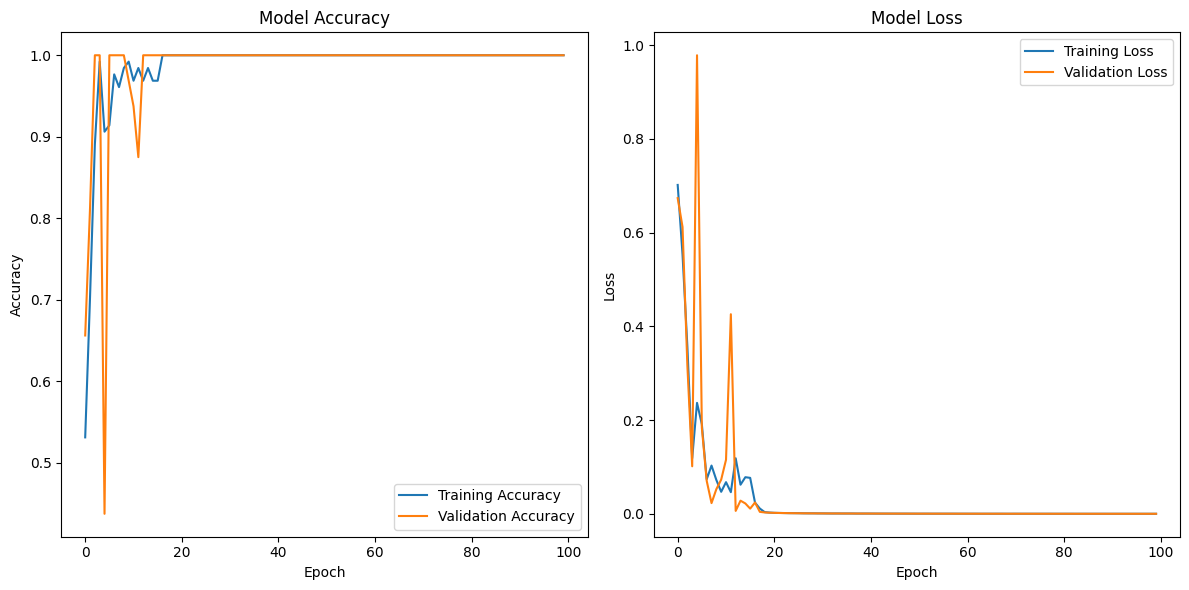

In [107]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_genimgs.history['accuracy'], label='Training Accuracy')
plt.plot(history_genimgs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_genimgs.history['loss'], label='Training Loss')
plt.plot(history_genimgs.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [108]:
model_genimgs = load_model('best_model_genimgs.keras')
loss, accuracy = model_genimgs.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9729 - loss: 0.1802  
Test Accuracy: 97.50%
Errors = 1


### 1.7.3 VQVAE + GAN

In [8]:
gen_imgs = np.load('VQVAE_MLPGAN_gunpoint.npy').squeeze(1)
gen_ohe_labels = np.load('labels_vqvae_gan.npy')
gen_imgs.shape , gen_ohe_labels.shape

((200, 150, 150), (200, 2))

In [9]:
def transform_labels(gen_ohe_labels):
    return np.where(gen_ohe_labels == 1)[-1]

gen_labels = transform_labels(gen_ohe_labels)
print(gen_labels)
gen_imgs.shape , gen_labels.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


((200, 150, 150), (200,))

In [10]:
def random_idx_selection(gen_labels,seed=0, cls = 0, amount = 72):
    indices_class_x = np.where(gen_labels == cls)[0]
    np.random.seed(seed)

    # Randomly select 80 indices of class 0
    selected_indices = np.random.choice(indices_class_x, size=amount, replace=False)
    assert(selected_indices.all() < len(gen_labels)/2)
    return selected_indices

selected_idx = random_idx_selection(gen_labels)
selected_idx

array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29])

In [11]:
# rebalacing the vector
selected_elements = gen_imgs[selected_idx]
selected_labels = gen_labels[selected_idx]
X_train_rebalanced = np.concatenate((X_train_reduced_gasf,selected_elements))
y_train_rebalanced = np.concatenate((y_train_reduced,selected_labels))
X_train_rebalanced.shape , y_train_rebalanced.shape, y_train_rebalanced.sum()

((160, 150, 150), (160,), 80)

In [14]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

genimgs_model = build_model((X_train_rebalanced.shape[1], X_train_rebalanced.shape[2]))

# Create a ModelCheckpoint callback and Early stop
early_stop = EarlyStopping(monitor='val_loss',patience = 5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_genimgs_vqvaegan.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_genimgs = genimgs_model.fit(X_train_rebalanced, y_train_rebalanced, epochs=100, batch_size=16, validation_split=0.2,callbacks=[checkpoint,early_stop])

Epoch 1/100


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5686 - loss: 0.6490
Epoch 1: val_loss improved from inf to 0.36393, saving model to best_model_genimgs_vqvaegan.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.5968 - loss: 0.6323 - val_accuracy: 1.0000 - val_loss: 0.3639
Epoch 2/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8844 - loss: 0.3645
Epoch 2: val_loss improved from 0.36393 to 0.05537, saving model to best_model_genimgs_vqvaegan.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8956 - loss: 0.3352 - val_accuracy: 1.0000 - val_loss: 0.0554
Epoch 3/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9113 - loss: 0.2349
Epoch 3: val_loss did not improve from 0.05537
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9173 - loss: 0.2257 - val_accuracy: 1.0000 - val_loss: 0.0707
Epoch 4/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9936 - loss: 0.0624
Epoch 4: val_loss improved from 0.05537 to 0.02416, saving model to best_model_genimgs

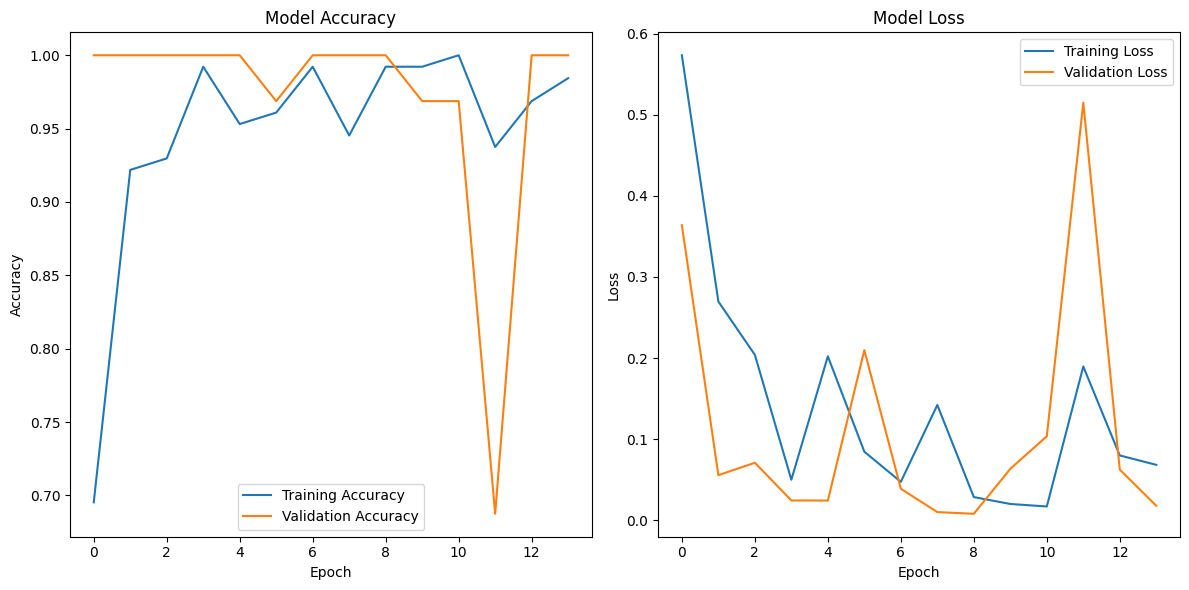

In [15]:
# Plotting training & validation accuracy
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history_genimgs.history['accuracy'], label='Training Accuracy')
plt.plot(history_genimgs.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history_genimgs.history['loss'], label='Training Loss')
plt.plot(history_genimgs.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()  # Adjusts the plots to prevent overlap
plt.show()

In [16]:
model_genimgs = load_model('best_model_genimgs_vqvaegan.keras')
loss, accuracy = model_genimgs.evaluate(X_test_gasf, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Errors = {round(len(y_test) - len(y_test)*accuracy)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8750 - loss: 0.3001
Test Accuracy: 87.50%
Errors = 5
